# MUDAB2G1 - Grupo 3 - TFM: Modelo de predicción de precios de acciones

Este notebook pertenece al Grupo 3 del MUDAB2G1. Cuyos miembros de equipo son:

*   Carrillo Ng, Sebastián Elías
*   Cifuentes Guzmán, Yaros Josué
*   Donoso Muñoz, Javier Esteban

## Objetivo del notebook: Modelo de predicción de acciones bursátiles

El objetivo de este notebook es desarrollar un modelo de predicción del precio de acciones que integre tanto variables financieras estructuradas como información cualitativa proveniente de noticias económicas. Para ello, se implementará un enfoque de aprendizaje automático basado en redes neuronales recurrentes, diseñadas para capturar patrones temporales complejos en series de tiempo multivariadas.

## Preparación del entorno

En este apartado se prepararon los elementos necesarios para el desarrollo del proyecto, incluyendo la carga y procesamiento de los datos a partir de archivos CSV:

*   Descargamos e importamos todas las librerías necesarias
*   Parametrizamos datos que utilizaremos reiteradamente, como las fechas para separar nuestros conjuntos de Train/Test/Validation.
*   Añadimos todos los dataframes necesarios para crear nuestro data final. Esto incluye datos financieros de la acción, análisis de sentimiento y datos macroeconómicos.





### Librerias

In [ ]:
!pip install optuna-integration[tfkeras] &> /dev/null
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from optuna.integration.tfkeras import TFKerasPruningCallback
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras import regularizers
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from sklearn.utils import resample
import matplotlib.pyplot as plt
from datetime import timedelta
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow
import itertools
import datetime
import warnings
import optuna
import random
import time

warnings.filterwarnings("ignore")
tensorflow.random.set_seed(42)
np.random.seed(42)
random.seed(42)

### Lectura de Datasets

In [ ]:
# Creación y Lectura de DataFrames
# Stock Data
stock_data = pd.read_csv("tesla_stock.csv", parse_dates=['date'])
stock_data['ema5'] = stock_data['close'].ewm(span=5, adjust=False).mean()
stock_data['ema20'] = stock_data['close'].ewm(span=20, adjust=False).mean()
stock_data_columns = stock_data.columns.drop('date')

# Finbert Sentiment Data
finbert_sentiment_data = pd.read_csv("tesla_sentiment.csv")
finbert_sentiment_data['date'] = pd.to_datetime(finbert_sentiment_data['publish_date'])
finbert_sentiment_data = finbert_sentiment_data[['date','finbert_final_sentiment']]

# Finbert Embbedings Data
finbert_embedding_data = pd.read_csv("tesla_sentiment.csv")
finbert_embedding_data['date'] = pd.to_datetime(finbert_embedding_data['publish_date'])
finbert_embedding_data = finbert_embedding_data.drop(columns=['publish_date','finbert_final_sentiment'])
embeddings_columns = finbert_embedding_data.columns.drop('date')

# Macroeconomic Data
macroeconomic_variables = pd.read_csv("macroeconomic_variables.csv")
macroeconomic_variables['date'] = pd.to_datetime(macroeconomic_variables['date'])

# Merged Data
start_date = '2019-01-01'
end_date = '2024-12-31'
base_df = pd.DataFrame({'date': stock_data['date'].sort_values()})
base_df = base_df[(base_df['date'] >= start_date) & (base_df['date'] <= end_date)]
merged_df = pd.merge(base_df, stock_data, on='date', how='left')
merged_df = pd.merge(merged_df, finbert_sentiment_data, on='date', how='left')
merged_df = pd.merge(merged_df, finbert_embedding_data, on='date', how='left')
merged_df = pd.merge(merged_df, macroeconomic_variables, on='date', how='left')
merged_df.set_index("date", inplace=True)
merged_df = merged_df.fillna(method='ffill')


### Parametrizacion de fechas

In [ ]:
# Definición de parámetros
forecast_horizon = 20 # dias a predecir, 20 trading days, aprox. un mes calendario
look_back        = forecast_horizon * 3 # look back que usa el modelo para generar la prediccion
trading_days     = merged_df.index.sort_values()

# Rangos de fechas
train_dates      = trading_days[(trading_days >= '2019-01-01') & (trading_days <= '2022-12-31')] # entrenamiento
val_dates        = trading_days[(trading_days >= '2023-01-01') & (trading_days <= '2023-12-31')] # validacion
test_dates       = trading_days[(trading_days >= '2024-01-01') & (trading_days <= '2024-12-31')] # test

# Seleccion individual de inicio y final
train_start      = train_dates[0]
train_end        = train_dates[-1]
val_start        = val_dates[0]
val_end          = val_dates[-1]

# "i" selecciona el punto inicial dentro del rango de testeo. Se elige i=75 como ejemplo
i = 75
predict_start    = test_dates[i]
predict_end      = test_dates[i + forecast_horizon - 1]
visual_start     = test_dates[i - look_back] if i >= look_back else val_dates[i-look_back]
visual_end       = predict_end
target_variable  = 'ema5' # variable a predecir



## Primer modelo de predicción: Arima

### Características

Se implementó un modelo ARIMA univariado, optimizado a través de Grid Search para los parámetros (p, d, q), empleando el AIC como criterio de selección. El modelo fue entrenado sobre datos históricos y utilizado para pronóstico multistep, siendo evaluado mediante MAE, MAPE, RMSE, RMSPE y MDA.

### Modelo

In [ ]:
# Cronómetro para desarrollo del modelo
arima_start_time = time.time()

# Separación Train/Test
arima_train = merged_df.loc[merged_df.index[merged_df.index.get_loc(predict_start) - 200] : merged_df.index[merged_df.index.get_loc(predict_start) - 1],target_variable].copy()
arima_test = merged_df.loc[predict_start : predict_end, target_variable].copy()

# Empleamos un GridSearch para encontrar la combinación óptima de parametros (p,d,q)
best_aic = float('inf')
best_order = None

for p in range(1, 9, 3):
    for d in range(0, 7, 3):
        for q in range(0, 7, 3):
            try:
                model = ARIMA(arima_train, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic

                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA order: {best_order}")

# Entrenamiento de modelo
arima_model = ARIMA(arima_train, order=best_order)
arima_model_fit = arima_model.fit()

# Predicción
arima_forecast = arima_model_fit.forecast(steps=forecast_horizon)
arima_forecast = pd.Series(arima_forecast.values, index=arima_test.index)

# Cálculo de metricas
arima_mae = mean_absolute_error(arima_test, arima_forecast)
arima_mape = mean_absolute_percentage_error(arima_test,arima_forecast)*100
arima_rmse = np.sqrt(mean_squared_error(arima_test, arima_forecast))
arima_rmspe = np.sqrt(np.mean(((arima_test - arima_forecast) / arima_test) ** 2)) * 100
arima_mda = (np.sign(arima_test.diff()) == np.sign(arima_forecast.diff())).mean()
arima_end_time = time.time()
arima_development_time = (arima_end_time - arima_start_time)/60

print(f"Development time: {arima_development_time:.1f} minutes")
print(f"MAE: {arima_mae:.2f}")
print(f"MAPE: {arima_mape:.2f}%")
print(f"RMSE: {arima_rmse:.2f}")
print(f"RMSPE: {arima_rmspe:.2f}%")
print(f"MDA: {arima_mda:.2%}")


Best ARIMA order: (4, 3, 6)
Development time: 1.4 minutes
MAE: 29.34
MAPE: 16.75%
RMSE: 33.51
RMSPE: 19.03%
MDA: 40.00%


### Visualizacion ARIMA


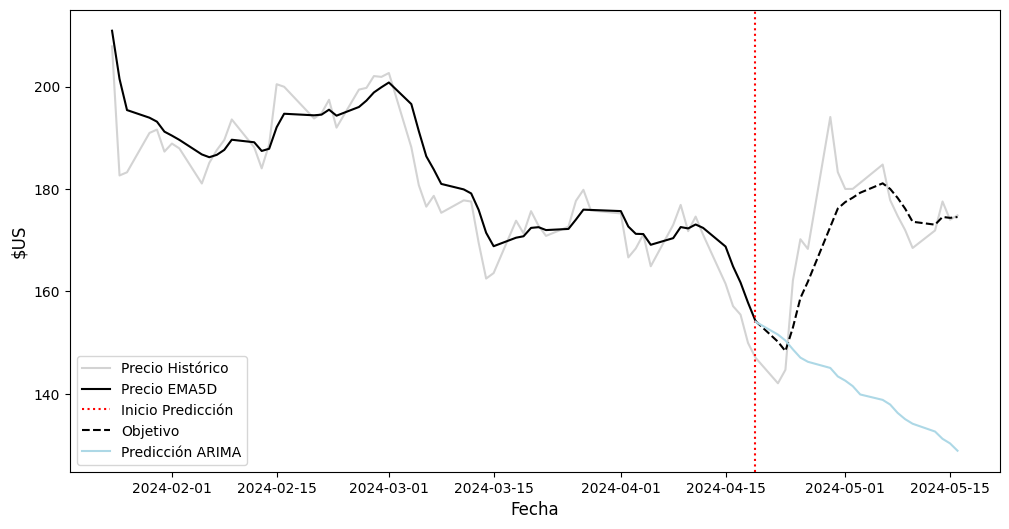

In [ ]:
# Visualización
plt.figure(figsize=(12, 6))
plt.plot(merged_df['close'].loc[visual_start:predict_end], label="Precio Histórico", color='lightgray')
plt.plot(merged_df[target_variable].loc[visual_start:predict_start], label="Precio EMA5D", color='black')
plt.axvline(pd.to_datetime(predict_start), color='red', linestyle='dotted', label='Inicio Predicción')
plt.plot(arima_test, label='Objetivo',color = 'black',linestyle='--')
plt.plot(arima_forecast, label="Predicción ARIMA", color='lightblue')
plt.xlabel("Fecha", fontsize = 12)
plt.ylabel("$US", fontsize = 12)
plt.legend()
plt.show()


## Segundo modelo de predicción: Basic LSTM

### Características

Modelo LSTM multivariado diseñado para predicción financiera multistep. Utiliza datos escalados y secuencias temporales (look_back) como entrada para una red compuesta por dos capas LSTM (64 y 32 unidades), una capa densa y una capa de Dropout. Optimiza con el algoritmo Adam y la función de pérdida MSE. La evaluación se realiza mediante MAE, MAPE, RMSE, RMSPE y MDA. Para la visualización de resultados se aplica un suavizado EMA.

### Modelo

In [ ]:
# Cronómetro para desarrollo del modelo
basic_lstm_start_time = time.time()

# Definicion de features para nuestro modelo
basic_lstm_features = [col for col in stock_data_columns if col != target_variable]

# Separación Train/Validation/Test
basic_lstm_train = merged_df.loc[train_start:train_end].copy()
basic_lstm_val = merged_df.loc[merged_df.index[merged_df.index.get_loc(val_start) - look_back] : val_end].copy()
basic_lstm_test = merged_df.loc[merged_df.index[merged_df.index.get_loc(predict_start) - look_back]:predict_end].copy()

# Generamos Scalers para nuestras features y variable objetivo
basic_lstm_scaler = RobustScaler()
basic_lstm_scaler.fit(basic_lstm_train[basic_lstm_features])
basic_lstm_target_scaler = StandardScaler()
basic_lstm_target_scaler.fit(basic_lstm_train[[target_variable]])

# Escalado de datos de acuerdo a train (Features)
basic_lstm_train_scaled = basic_lstm_train[basic_lstm_features].copy()
basic_lstm_val_scaled = basic_lstm_val[basic_lstm_features].copy()
basic_lstm_test_scaled = basic_lstm_test[basic_lstm_features].copy()
basic_lstm_train_scaled[basic_lstm_features] = basic_lstm_scaler.transform(basic_lstm_train[basic_lstm_features])
basic_lstm_val_scaled[basic_lstm_features] = basic_lstm_scaler.transform(basic_lstm_val[basic_lstm_features])
basic_lstm_test_scaled[basic_lstm_features] = basic_lstm_scaler.transform(basic_lstm_test[basic_lstm_features])

# Escalado de datos de acuerdo a train (Variable Objetivo)
basic_lstm_train_scaled[target_variable] = basic_lstm_target_scaler.transform(basic_lstm_train[[target_variable]]).flatten()
basic_lstm_val_scaled[target_variable] = basic_lstm_target_scaler.transform(basic_lstm_val[[target_variable]]).flatten()
basic_lstm_test_scaled[target_variable] = basic_lstm_target_scaler.transform(basic_lstm_test[[target_variable]]).flatten()

# Features escaladas
basic_lstm_features = basic_lstm_features + [target_variable]

# Preparación de input para LSTM
def create_sequences_basic_lstm(data):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon + 1):
        X.append(data[basic_lstm_features].iloc[i:i+look_back].values)
        y.append(data[target_variable].iloc[i+look_back:i+look_back+forecast_horizon].values)
    return np.array(X), np.array(y)

basic_lstm_X_train, basic_lstm_y_train = create_sequences_basic_lstm(basic_lstm_train_scaled)
basic_lstm_X_val, basic_lstm_y_val = create_sequences_basic_lstm(basic_lstm_val_scaled)
basic_lstm_X_test, basic_lstm_y_test = create_sequences_basic_lstm(basic_lstm_test_scaled)

# Arquitectura del modelo
basic_lstm = Sequential()
basic_lstm.add(LSTM(units=64, input_shape=(basic_lstm_X_train.shape[1], basic_lstm_X_train.shape[2]), return_sequences=True, kernel_regularizer=regularizers.l2(0.0005)))
basic_lstm.add(Dropout(0.25))
basic_lstm.add(LSTM(units=32, return_sequences=False, kernel_regularizer=regularizers.l2(0.0005)))
basic_lstm.add(Dropout(0.25))
basic_lstm.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
basic_lstm.add(Dropout(0.25))
basic_lstm.add(Dense(forecast_horizon))
basic_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento y Validación
basic_lstm_history = basic_lstm.fit(basic_lstm_X_train, basic_lstm_y_train,
                                    validation_data=(basic_lstm_X_val, basic_lstm_y_val),
                                    epochs=30,
                                    batch_size=64,
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                                    verbose=1)

# Desescalado de predicciones
basic_lstm_prediction_index = basic_lstm_test.index[-forecast_horizon:]
basic_lstm_predictions = basic_lstm.predict(basic_lstm_X_test)
basic_lstm_unscaled_predictions = basic_lstm_target_scaler.inverse_transform(basic_lstm_predictions[0].reshape(-1,1)).flatten()
basic_lstm_unscaled_predictions = pd.Series(basic_lstm_unscaled_predictions, index=basic_lstm_prediction_index)

# Desescalado de valores reales
basic_lstm_unscaled_true = basic_lstm_target_scaler.inverse_transform(basic_lstm_y_test[0].reshape(-1, 1)).flatten()
basic_lstm_unscaled_true = pd.Series(basic_lstm_unscaled_true, index=basic_lstm_prediction_index)

# Aplicamos un suavizado a nuestra predicción, unicamente para la visualización
basic_lstm_predictions_ema = basic_lstm_unscaled_predictions.ewm(span = 5, adjust = False).mean()

# Cálculo de métricas
basic_lstm_mae = mean_absolute_error(basic_lstm_unscaled_true, basic_lstm_unscaled_predictions)
basic_lstm_mape = mean_absolute_percentage_error(basic_lstm_unscaled_true,basic_lstm_unscaled_predictions)*100
basic_lstm_rmse = np.sqrt(mean_squared_error(basic_lstm_unscaled_true, basic_lstm_unscaled_predictions))
basic_lstm_rmspe = np.sqrt(np.mean(((basic_lstm_unscaled_true - basic_lstm_unscaled_predictions) / basic_lstm_unscaled_true) ** 2)) * 100
basic_lstm_mda = np.mean(np.sign(np.diff(basic_lstm_unscaled_true)) == np.sign(np.diff(basic_lstm_unscaled_predictions)))
basic_lstm_end_time = time.time()
basic_lstm_development_time = (basic_lstm_end_time - basic_lstm_start_time)/60

print(f"Development time: {basic_lstm_development_time:.1f} minutes")
print(f"MAE:  {basic_lstm_mae:.2f}")
print(f"MAPE: {basic_lstm_mape:.2f}%")
print(f"RMSE: {basic_lstm_rmse:.2f}")
print(f"RMSPE: {basic_lstm_rmspe:.2f}%")
print(f"MDA:  {basic_lstm_mda:.2%}")


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.9328 - val_loss: 0.2945
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.6454 - val_loss: 0.2077
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.4839 - val_loss: 0.1598
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.3638 - val_loss: 0.1282
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.2969 - val_loss: 0.1065
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.2384 - val_loss: 0.0977
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.2187 - val_loss: 0.0919
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.1988 - val_loss: 0.0909
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.1898 - val_loss: 0.0865
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.1789 - val_loss: 0.0867
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.1614 - val_loss: 0.0854
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.

### Visualización Arima + Basic LSTM

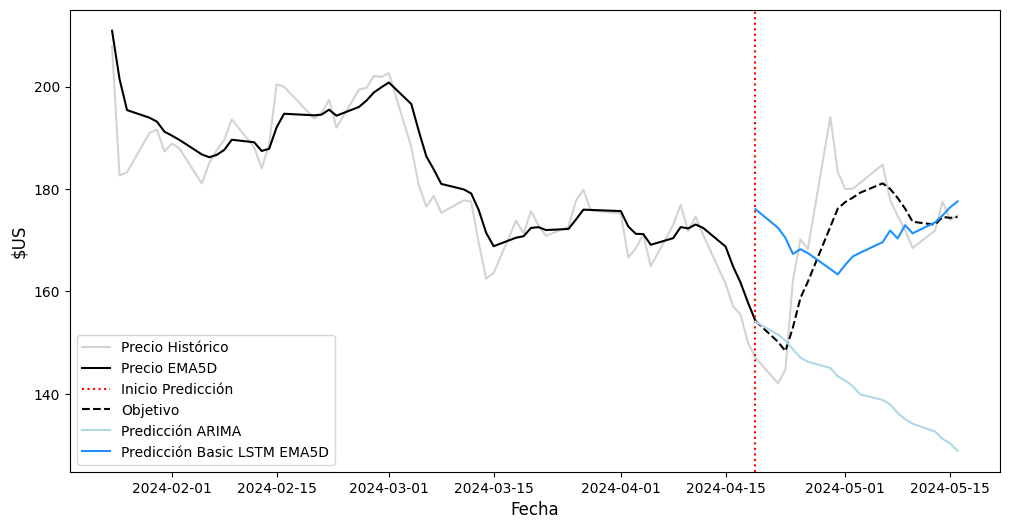

In [ ]:
# Visualización
plt.figure(figsize=(12, 6))
plt.plot(merged_df['close'].loc[visual_start:predict_end], label="Precio Histórico", color='lightgray')
plt.plot(merged_df[target_variable].loc[visual_start:predict_start], label="Precio EMA5D", color='black')
plt.axvline(pd.to_datetime(predict_start), color='red', linestyle='dotted', label='Inicio Predicción')
plt.plot(arima_test, label='Objetivo',color = 'black',linestyle='--')
plt.plot(arima_forecast, label="Predicción ARIMA", color='lightblue')
plt.plot(basic_lstm_predictions_ema, label="Predicción Basic LSTM EMA5D", color='dodgerblue')
plt.xlabel("Fecha", fontsize = 12)
plt.ylabel("$US", fontsize = 12)
plt.legend()
plt.show()


## Tercer modelo de predicción: LSTM Multivariado

### Características

Modelo Full LSTM multivariado orientado a predicción multistep, con reducción de variables basada en un análisis de importancia mediante Random Forest. Utiliza datos escalados y secuencias temporales como entrada para una red neuronal compuesta por dos capas LSTM (128 y 64 unidades), una capa densa y una capa de Dropout. La optimización se realiza con el algoritmo Adam y la función de pérdida MSE. El modelo es evaluado utilizando las métricas MAE, MAPE, RMSE, RMSPE y MDA

### Permutation Importance

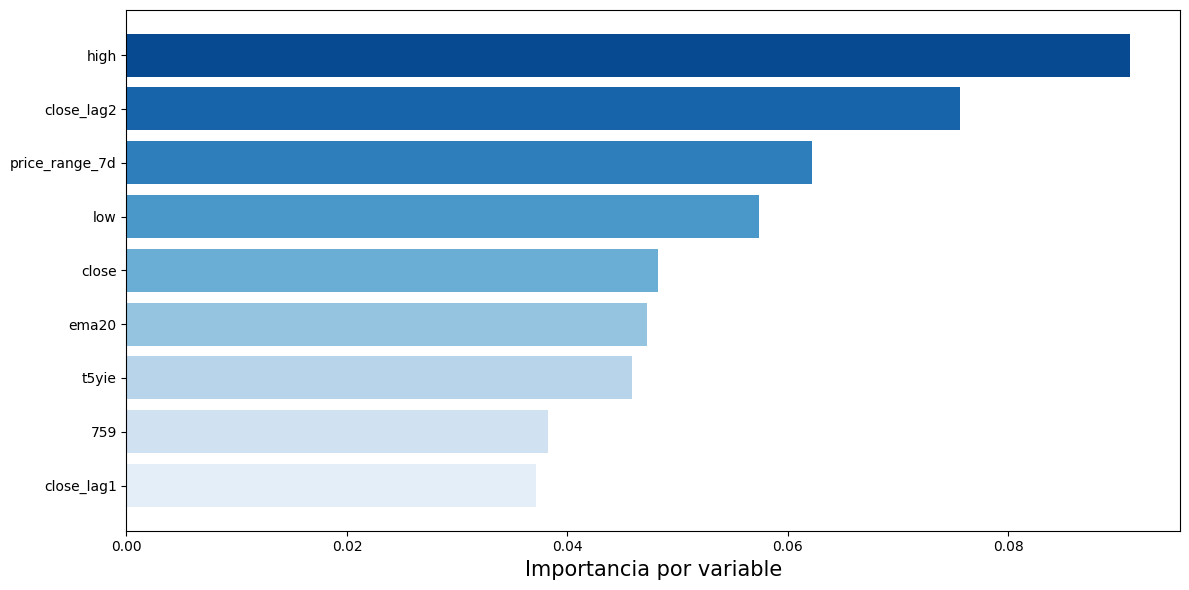

In [ ]:
# Cronómetro para desarrollo del modelo
full_lstm_start_time = time.time()

# Evaluamos las features más importantes para nuestro modelo, con el objetivo de reducir las variables a utilizar
features = basic_lstm_train.columns.drop(target_variable)
X, y = [], []

for i in tqdm(range(look_back, len(basic_lstm_train) - forecast_horizon)):
    window = basic_lstm_train.iloc[i - look_back:i][features]
    stats = window.mean().values
    target = basic_lstm_train.iloc[i + forecast_horizon - 1][target_variable]
    X.append(stats)
    y.append(target)

X = np.array(X)
y = np.array(y)

# Muestra parcial de ventanas para reducir tiempo de ejecución
X_sample, y_sample = resample(X, y, n_samples=int(len(X) * 0.33), random_state=42)

# Escalado
scaler = RobustScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# Split Train y Validation
X_train, X_val, y_train, y_val = train_test_split(X_sample_scaled, y_sample, test_size=0.2, random_state=42)

# Desarrollamos un Random Forest simple
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1)

rf.fit(X_train, y_train)

# Resultados de importancia
result = permutation_importance(rf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
importances = pd.DataFrame({'feature': features,
                            'importance': result.importances_mean}).sort_values(by='importance', ascending=False)

# Normalizamos importancias
importances['normalized'] = importances['importance'] / importances['importance'].sum()
importances['cumulative'] = importances['normalized'].cumsum()

# Filtramos las variables más importantes
top_vars = importances[importances['cumulative'] <= 0.8]
visualization_vars = importances[importances['cumulative'] <= 0.53]

# Visualización
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Blues", len(visualization_vars))[::-1]
plt.barh(visualization_vars['feature'], visualization_vars['normalized'], color=colors)
plt.xlabel('Importancia por variable', fontsize = 15)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Ejecución del modelo

In [ ]:
# Separación Train/Validation/Test
look_back = forecast_horizon * 3
full_lstm_train = merged_df.loc[train_start:train_end].copy()
full_lstm_val = merged_df.loc[merged_df.index[merged_df.index.get_loc(val_start) - look_back] : val_end].copy()
full_lstm_test = merged_df.loc[merged_df.index[merged_df.index.get_loc(predict_start) - look_back]:predict_end].copy()

# Obtenemos features para definir scalers
full_lstm_features = top_vars['feature'].tolist()

# Generamos Scalers para nuestras features y variable objetivo
full_lstm_scaler = RobustScaler()
full_lstm_scaler.fit(full_lstm_train[full_lstm_features])
full_lstm_target_scaler = StandardScaler()
full_lstm_target_scaler.fit(full_lstm_train[[target_variable]])

# Escalado de datos de acuerdo a train (Features)
full_lstm_train_scaled = full_lstm_train[full_lstm_features].copy()
full_lstm_val_scaled = full_lstm_val[full_lstm_features].copy()
full_lstm_test_scaled = full_lstm_test[full_lstm_features].copy()
full_lstm_train_scaled[full_lstm_features] = full_lstm_scaler.transform(full_lstm_train[full_lstm_features])
full_lstm_val_scaled[full_lstm_features] = full_lstm_scaler.transform(full_lstm_val[full_lstm_features])
full_lstm_test_scaled[full_lstm_features] = full_lstm_scaler.transform(full_lstm_test[full_lstm_features])

# Escalado de datos de acuerdo a train (Variable Objetivo)
full_lstm_train_scaled[target_variable] = full_lstm_target_scaler.transform(full_lstm_train[[target_variable]]).flatten()
full_lstm_val_scaled[target_variable] = full_lstm_target_scaler.transform(full_lstm_val[[target_variable]]).flatten()
full_lstm_test_scaled[target_variable] = full_lstm_target_scaler.transform(full_lstm_test[[target_variable]]).flatten()

# Features escaladas + target_variable
full_lstm_features = full_lstm_features + [target_variable]

# Preparación de input para LSTM
def create_sequences_full_lstm(data):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon + 1):
        X.append(data[full_lstm_features].iloc[i:i+look_back].values)
        y.append(data[target_variable].iloc[i+look_back:i+look_back+forecast_horizon].values)
    return np.array(X), np.array(y)

full_lstm_X_train, full_lstm_y_train = create_sequences_full_lstm(full_lstm_train_scaled)
full_lstm_X_val, full_lstm_y_val = create_sequences_full_lstm(full_lstm_val_scaled)
full_lstm_X_test, full_lstm_y_test = create_sequences_full_lstm(full_lstm_test_scaled)

# Arquitectura del modelo
full_lstm = Sequential()
full_lstm.add(LSTM(units=128, input_shape=(full_lstm_X_train.shape[1], full_lstm_X_train.shape[2]), return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
full_lstm.add(Dropout(0.3))
full_lstm.add(LSTM(units=64, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)))
full_lstm.add(Dropout(0.3))
full_lstm.add(Dense(32, activation='linear', kernel_regularizer=regularizers.l2(0.001)))
full_lstm.add(Dropout(0.3))
full_lstm.add(Dense(forecast_horizon))
full_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento y Validación
full_lstm_history = full_lstm.fit(full_lstm_X_train, full_lstm_y_train,
                                    validation_data=(full_lstm_X_val, full_lstm_y_val),
                                    epochs=30,
                                    batch_size=64,
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                                    verbose=1)

# Desescalado de predicciones
full_lstm_prediction_index = full_lstm_test.index[-forecast_horizon:]
full_lstm_predictions = full_lstm.predict(full_lstm_X_test)
full_lstm_unscaled_predictions = full_lstm_target_scaler.inverse_transform(full_lstm_predictions[0].reshape(-1,1)).flatten()
full_lstm_unscaled_predictions = pd.Series(full_lstm_unscaled_predictions, index=full_lstm_prediction_index)

# Desescalado de valores reales
full_lstm_unscaled_true = full_lstm_target_scaler.inverse_transform(full_lstm_y_test[0].reshape(-1, 1)).flatten()
full_lstm_unscaled_true = pd.Series(full_lstm_unscaled_true, index=full_lstm_prediction_index)

# Aplicamos un suavizado a nuestra predicción, unicamente para la visualización
full_lstm_predictions_ema = full_lstm_unscaled_predictions.ewm(span = 5, adjust = False).mean()

# Cálculo de métricas
full_lstm_mae = mean_absolute_error(full_lstm_unscaled_true, full_lstm_unscaled_predictions)
full_lstm_mape = mean_absolute_percentage_error(full_lstm_unscaled_true,full_lstm_unscaled_predictions)*100
full_lstm_rmse = np.sqrt(mean_squared_error(full_lstm_unscaled_true, full_lstm_unscaled_predictions))
full_lstm_rmspe = np.sqrt(np.mean(((full_lstm_unscaled_true - full_lstm_unscaled_predictions) / full_lstm_unscaled_true) ** 2)) * 100
full_lstm_mda = np.mean(np.sign(np.diff(full_lstm_unscaled_true)) == np.sign(np.diff(full_lstm_unscaled_predictions)))
full_lstm_end_time = time.time()
full_lstm_development_time = (full_lstm_end_time - full_lstm_start_time)/60

print(f"Development time: {full_lstm_development_time:.1f} minutes")
print(f"MAE:  {full_lstm_mae:.2f}")
print(f"MAPE: {full_lstm_mape:.2f}%")
print(f"RMSE: {full_lstm_rmse:.2f}")
print(f"RMSPE: {full_lstm_rmspe:.2f}%")
print(f"MDA:  {full_lstm_mda:.2%}")


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 1.0833 - val_loss: 0.5427
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.6345 - val_loss: 0.4753
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 0.4781 - val_loss: 0.3459
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.3851 - val_loss: 0.3371
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - loss: 0.3253 - val_loss: 0.3153
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.2894 - val_loss: 0.3351
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.2581 - val_loss: 0.2713
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - loss: 0.2342 - val_loss: 0.2836
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - loss: 0.2181 - val_loss: 0.2592
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 0.1990 - val_loss: 0.2271
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - loss: 0.1856 - val_loss: 0.1846
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/ste

### Visualizacion Arima + LSTM (Basic, Full)

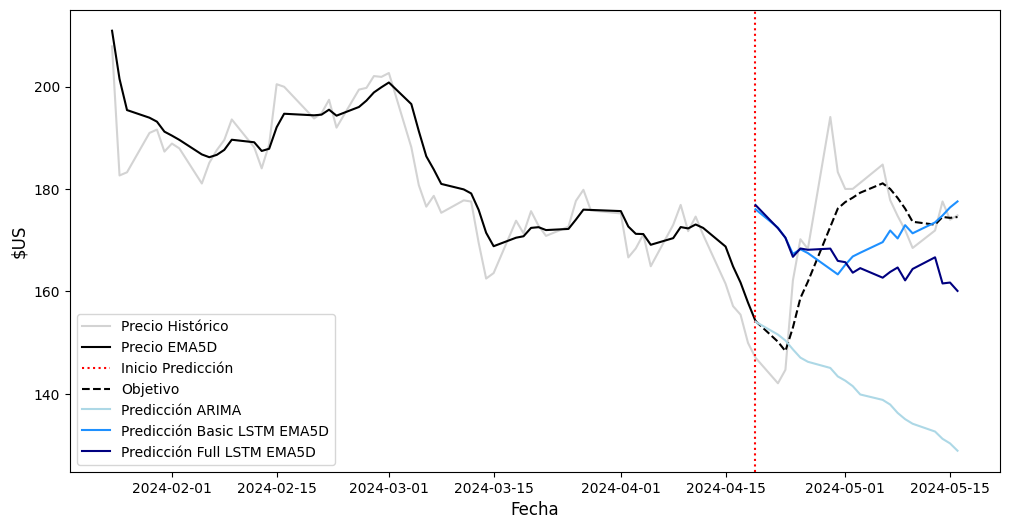

In [ ]:
# Visualización
plt.figure(figsize=(12, 6))
plt.plot(merged_df['close'].loc[visual_start:predict_end], label="Precio Histórico", color='lightgray')
plt.plot(merged_df[target_variable].loc[visual_start:predict_start], label="Precio EMA5D", color='black')
plt.axvline(pd.to_datetime(predict_start), color='red', linestyle='dotted', label='Inicio Predicción')
plt.plot(arima_test, label='Objetivo',color = 'black',linestyle='--')
plt.plot(arima_forecast, label="Predicción ARIMA", color='lightblue')
plt.plot(basic_lstm_predictions_ema, label="Predicción Basic LSTM EMA5D", color='dodgerblue')
plt.plot(full_lstm_predictions_ema, label="Predicción Full LSTM EMA5D", color='navy')
plt.xlabel("Fecha", fontsize = 12)
plt.ylabel("$US", fontsize = 12)
plt.legend()
plt.show()


## Cuarto modelo de predicción: Rolling LSTM

### Características

Modelo Rolling LSTM multivariado con reducción a las 10 variables más relevantes (que acumulan más del 53 % de importancia). Implementa un esquema de predicción rolling forecast a 10 días, utilizando una ventana de entrada (look_back) de 60 días. Aplica escalado robusto a las variables predictoras y escalado estándar al objetivo. La arquitectura incluye dos capas LSTM (128 y 64 unidades), una capa densa, regularización L2 y Dropout. El entrenamiento incorpora EarlyStopping. La evaluación se realiza con MAE, MAPE, RMSE, RMSPE y MDA, aplicadas sobre predicciones promedio diarias.

### Ejecución del modelo

In [ ]:
# Cronómetro para desarrollo del modelo
rolling_lstm_start_time = time.time()

# Definicion de features para nuestro modelo
top_n = 9
top_features = importances.sort_values(by="importance", ascending=False).head(top_n)["feature"].tolist()
rolling_lstm_features = top_features

# Modificamos forecast_horizon a 10 días hábiles
forecast_horizon = 10

# Separación Train/Validation/Test
rolling_lstm_train = merged_df.loc[train_start:train_end].copy()
rolling_lstm_val = merged_df.loc[merged_df.index[merged_df.index.get_loc(val_start) - look_back] : val_end].copy()
rolling_lstm_test = merged_df.loc[merged_df.index[merged_df.index.get_loc(test_dates[0]) - look_back]:test_dates[-1]].copy()

# Generamos Scalers para nuestras features y variable objetivo
rolling_lstm_scaler = RobustScaler()
rolling_lstm_scaler.fit(rolling_lstm_train[rolling_lstm_features])
rolling_lstm_target_scaler = StandardScaler()
rolling_lstm_target_scaler.fit(rolling_lstm_train[[target_variable]])

# Escalado de datos de acuerdo a train (Features)
rolling_lstm_train_scaled = rolling_lstm_train[rolling_lstm_features].copy()
rolling_lstm_val_scaled = rolling_lstm_val[rolling_lstm_features].copy()
rolling_lstm_test_scaled = rolling_lstm_test[rolling_lstm_features].copy()
rolling_lstm_train_scaled[rolling_lstm_features] = rolling_lstm_scaler.transform(rolling_lstm_train[rolling_lstm_features])
rolling_lstm_val_scaled[rolling_lstm_features] = rolling_lstm_scaler.transform(rolling_lstm_val[rolling_lstm_features])
rolling_lstm_test_scaled[rolling_lstm_features] = rolling_lstm_scaler.transform(rolling_lstm_test[rolling_lstm_features])

# Escalado de datos de acuerdo a train (Variable Objetivo)
rolling_lstm_train_scaled[target_variable] = rolling_lstm_target_scaler.transform(rolling_lstm_train[[target_variable]]).flatten()
rolling_lstm_val_scaled[target_variable] = rolling_lstm_target_scaler.transform(rolling_lstm_val[[target_variable]]).flatten()
rolling_lstm_test_scaled[target_variable] = rolling_lstm_target_scaler.transform(rolling_lstm_test[[target_variable]]).flatten()

# Features escaladas
rolling_lstm_features = rolling_lstm_features + [target_variable]

# Preparación de input para LSTM
def create_sequences_rolling_lstm(data):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon + 1):
        X.append(data[rolling_lstm_features].iloc[i:i+look_back].values)
        y.append(data[target_variable].iloc[i+look_back:i+look_back+forecast_horizon].values)
    return np.array(X), np.array(y)

def create_sequences_test_extended(data):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[rolling_lstm_features].iloc[i:i+look_back].values)
        end_idx = min(i + look_back + forecast_horizon, len(data))
        actual_horizon = end_idx - (i + look_back)
        if actual_horizon > 0:
            y_vals = data[target_variable].iloc[i+look_back:end_idx].values
            if len(y_vals) < forecast_horizon:
                y_vals = np.pad(y_vals, (0, forecast_horizon - len(y_vals)), constant_values=np.nan)
            y.append(y_vals)
        else:
            y.append(np.full(forecast_horizon, np.nan))
    return np.array(X), np.array(y)

rolling_lstm_X_train, rolling_lstm_y_train = create_sequences_rolling_lstm(rolling_lstm_train_scaled)
rolling_lstm_X_val, rolling_lstm_y_val = create_sequences_rolling_lstm(rolling_lstm_val_scaled)
rolling_lstm_X_test, rolling_lstm_y_test = create_sequences_test_extended(rolling_lstm_test_scaled)

# Arquitectura del modelo
rolling_lstm = Sequential()
rolling_lstm.add(LSTM(units=128, input_shape=(rolling_lstm_X_train.shape[1], rolling_lstm_X_train.shape[2]), return_sequences=True, kernel_regularizer=regularizers.l2(0.0005)))
rolling_lstm.add(Dropout(0.35))
rolling_lstm.add(LSTM(units=64, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)))
rolling_lstm.add(Dropout(0.35))
rolling_lstm.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
rolling_lstm.add(Dropout(0.35))
rolling_lstm.add(Dense(forecast_horizon))
rolling_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento y Validación
rolling_lstm_history = rolling_lstm.fit(rolling_lstm_X_train, rolling_lstm_y_train,
                                    validation_data=(rolling_lstm_X_val, rolling_lstm_y_val),
                                    epochs=30,
                                    batch_size=64,
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                                    verbose=1)

# Generamos predicciones diarias
all_predictions = rolling_lstm.predict(rolling_lstm_X_test, verbose=0)
all_predictions_unscaled = rolling_lstm_target_scaler.inverse_transform(all_predictions)
prediction_df = pd.DataFrame(all_predictions_unscaled)
test_start_dates = rolling_lstm_test.index[look_back:]
prediction_df.index = test_start_dates
n_test_days = len(rolling_lstm_test) - look_back
prediction_matrix = np.full((len(prediction_df), n_test_days), np.nan)
all_test_dates = rolling_lstm_test.index[look_back:]

for i, start_date in enumerate(test_start_dates):
    start_idx = rolling_lstm_test.index.get_loc(start_date) - rolling_lstm_test.index.get_loc(rolling_lstm_test.index[look_back])
    end_idx = min(start_idx + forecast_horizon, n_test_days)
    prediction_matrix[i, start_idx:end_idx] = all_predictions_unscaled[i, :end_idx-start_idx]

# Promedio de predicciones diario
averaged_predictions = np.nanmean(prediction_matrix, axis=0)
prediction_counts = np.sum(~np.isnan(prediction_matrix), axis=0)
averaged_predictions_series = pd.Series(averaged_predictions, index=all_test_dates)
actual_values = rolling_lstm_test[target_variable].iloc[look_back:]

# Cálculo de métricas
rolling_mae = mean_absolute_error(actual_values, averaged_predictions_series)
rolling_mape = mean_absolute_percentage_error(actual_values, averaged_predictions_series) * 100
rolling_rmse = np.sqrt(mean_squared_error(actual_values, averaged_predictions_series))
rolling_rmspe = np.sqrt(np.mean(((actual_values - averaged_predictions_series) / actual_values) ** 2)) * 100
rolling_mda = np.mean(np.sign(np.diff(actual_values)) == np.sign(np.diff(averaged_predictions_series)))
rolling_lstm_end_time = time.time()
rolling_lstm_development_time = (rolling_lstm_end_time - rolling_lstm_start_time)/60

print(f"Development time: {rolling_lstm_development_time:.1f} minutes")
print(f"MAE:  {rolling_mae:.2f}")
print(f"MAPE: {rolling_mape:.2f}%")
print(f"RMSE: {rolling_rmse:.2f}")
print(f"RMSPE: {rolling_rmspe:.2f}%")
print(f"MDA:  {rolling_mda:.2%}")

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - loss: 0.9894 - val_loss: 0.3080
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.5833 - val_loss: 0.2521
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.4686 - val_loss: 0.2109
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.4011 - val_loss: 0.1842
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.3609 - val_loss: 0.1648
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3293 - val_loss: 0.1477
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.2896 - val_loss: 0.1299
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.2666 - val_loss: 0.1228
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 0.2531 - val_loss: 0.1137
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.2447 - val_loss: 0.1087
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.2246 - val_loss: 0.1010
Epoch 12/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - l

### Visualizacion Rolling LSTM

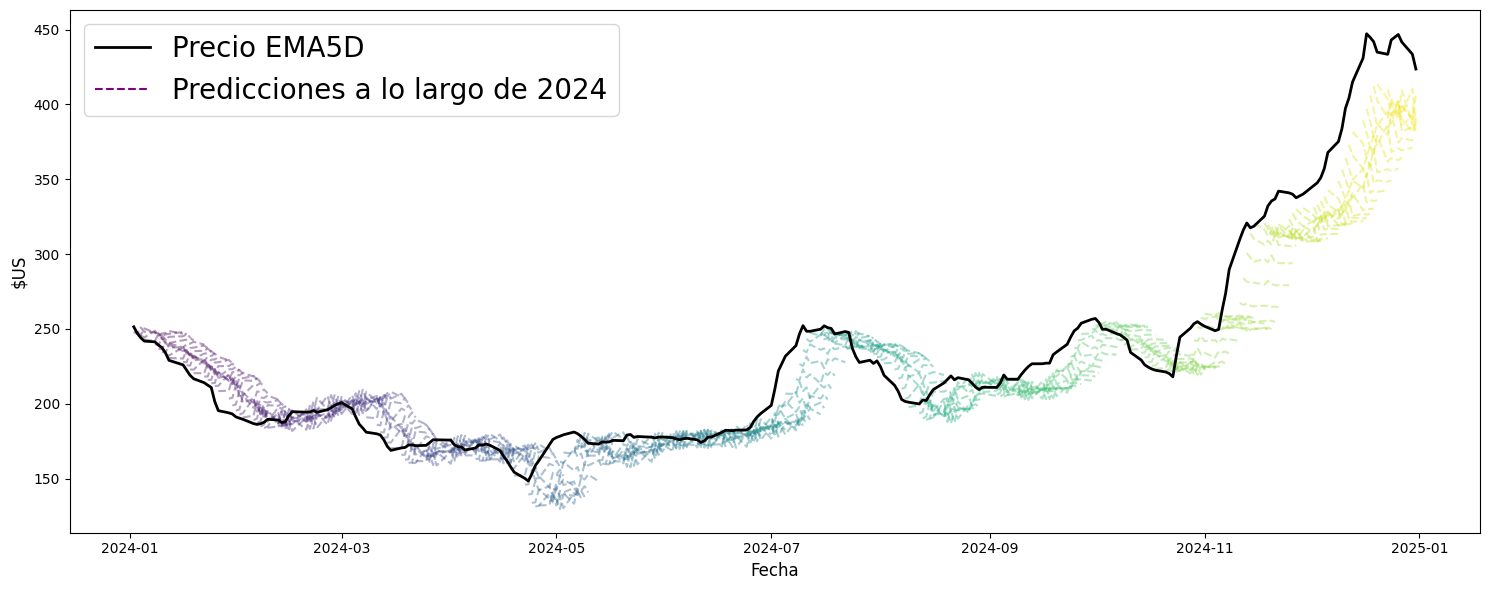

In [ ]:
# Predicciones diarias
plt.figure(figsize=(15, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(prediction_df)))
prediction_indices = np.linspace(0, len(prediction_df)-1, len(prediction_df), dtype=int)

for j, i in enumerate(prediction_indices):
    pred_values = all_predictions_unscaled[i]
    start_date = test_start_dates[i]
    start_idx = list(all_test_dates).index(start_date)
    end_idx = min(start_idx + forecast_horizon, len(all_test_dates))
    target_dates = all_test_dates[start_idx:end_idx]
    pred_subset = pred_values[:len(target_dates)]
    plt.plot(target_dates, pred_subset, '--', color=colors[j], alpha=0.4)

# Serie real
plt.plot(actual_values.index, actual_values.values, 'k-', linewidth=2)

custom_lines = [
    Line2D([0], [0], color='black', lw=2, label='Precio EMA5D'),
    Line2D([0], [0], color='purple', linestyle='--', lw=1.5, label='Predicciones a lo largo de 2024')
]
plt.legend(handles=custom_lines, loc='upper left', fontsize = 20)

plt.xlabel("Fecha", fontsize=12)
plt.ylabel("$US", fontsize=12)
plt.tight_layout()
plt.show()


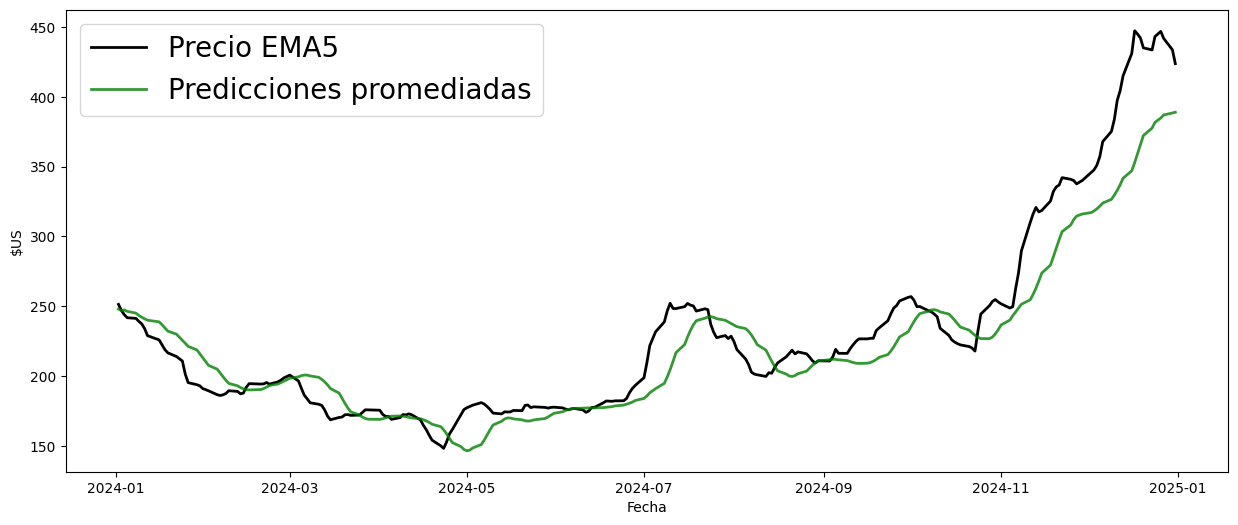

In [ ]:
# Predicciones Promediadas
plt.figure(figsize=(15, 6))
plt.plot(actual_values.index, actual_values.values,
         'k-', linewidth=2, label='Precio EMA5')
plt.plot(averaged_predictions_series.index, averaged_predictions_series.values,
         'g-', linewidth=2, label='Predicciones promediadas', alpha=0.8)
plt.xlabel('Fecha')
plt.ylabel('$US')
plt.legend(fontsize =20)
plt.show()
